In [ ]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import torch

from torchvision.utils import make_grid

from data.dataloader import *
from data.utils import *
from model.model import *
from engine import *


/home/user/anaconda3/envs/jih_icicic/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
def seed_everything(seed=42):
    random.seed(a=seed)
    np.random.seed(seed=seed)
    torch.manual_seed(seed=seed)
    torch.cuda.manual_seed(seed=seed)  # GPU 환경에서도 동일한 seed 적용
    torch.cuda.manual_seed_all(seed=seed)  # Multi-GPU 사용 시
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


In [ ]:
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(seed=worker_seed)
    random.seed(a=worker_seed)


In [ ]:
g = torch.Generator()
g.manual_seed(42)


In [ ]:
def get_hparams():
    hparams = {
        # 모델 구조
        "image_size": 512,
        "offset": 0.5,
        "cutoff": 0.3,

        # 손실 함수 가중치 (losses.py 기준)
        "lambda_col": 100.0,
        "lambda_exp": 1.0,
        "lambda_spa": 10.0,
        "lambda_tva": 1.0,

        # 최적화 및 학습 설정
        "optim": "sgd",
        "lr": 1e-7,
        "decay": 1e-8,
        "epochs": 100,
        "patience": 30,
        "batch_size": 8,
        "seed": random.randint(a=0, b=10000),

        # 데이터 경로
        "train_data_path": "data/1_train",
        "valid_data_path": "data/2_valid",
        "bench_data_path": "data/3_bench",
        "infer_data_path": "data/4_infer",

        # 로깅 설정
        "log_dir": "./runs/HomomorphicUnet/optims/ReduceActz",
        "experiment_name": "test",
        "inference": "inference",
    }
    return hparams


hparams = get_hparams()


In [ ]:
engine = LightningEngine(
    model=HomomorphicUnetLightning,
    hparams=hparams,
    ckpt="runs/HomomorphicUnet/optims/ReduceActz/rmsprop/version_0/nan_ckpt.ckpt"
)


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [ ]:
transform = DataTransform(image_size=512)
dataset = CustomDataset(
    path="data/1_train/2_LOLv2dataset", transform=transform)
loader = DataLoader(
    dataset=dataset,
    batch_size=hparams["batch_size"],
    shuffle=True,
    num_workers=int(os.cpu_count() * 0.9),
    persistent_workers=True,
    pin_memory=True,
    worker_init_fn=seed_worker,
    generator=g
)

d_b = next(iter(loader))


In [ ]:
hsirL = engine.model(hparams)
hsir = hsirL.model


Loading pretrained model LPIPS from /home/user/.cache/torch/hub/pyiqa/LPIPS_v0.1_alex-df73285e.pth


In [ ]:
y_b, cr_b, cb_b = hsir.rgb2ycrcb(d_b)
xi_b, xd_b = hsir.homo_separate(y_b)
oi_b = hsir.unet(xi_b)
ni_b = hsir.refine(xi_b, oi_b)
ny_b = ni_b * xd_b
eh_b = hsir.ycrcb2rgb(ny_b, cr_b, cb_b)


In [ ]:
d = d_b[0]
y, cr, cb = y_b[0], cr_b[0], cb_b[0]
xi, xd = xi_b[0], xd_b[0]
oi = oi_b[0]
ni = ni_b[0]
ny = ny_b[0]
eh = eh_b[0]


In [ ]:
d = (d.permute(1, 2, 0).detach().cpu().numpy()
     * 255).clip(0, 255).astype(np.uint8)
y = (y.permute(1, 2, 0).detach().cpu().numpy()
     * 255).clip(0, 255).astype(np.uint8)
cr = (cr.permute(1, 2, 0).detach().cpu().numpy()
      * 255).clip(0, 255).astype(np.uint8)
cb = (cb.permute(1, 2, 0).detach().cpu().numpy()
      * 255).clip(0, 255).astype(np.uint8)
xi = (xi.permute(1, 2, 0).detach().cpu().numpy()
      * 255).clip(0, 255).astype(np.uint8)
xd = (xd.permute(1, 2, 0).detach().cpu().numpy()
      * 255).clip(0, 255).astype(np.uint8)
oi = (oi.permute(1, 2, 0).detach().cpu().numpy()
      * 255).clip(0, 255).astype(np.uint8)
ni = (ni.permute(1, 2, 0).detach().cpu().numpy()
      * 255).clip(0, 255).astype(np.uint8)
ny = (ny.permute(1, 2, 0).detach().cpu().numpy()
      * 255).clip(0, 255).astype(np.uint8)
eh = (eh.permute(1, 2, 0).detach().cpu().numpy()
      * 255).clip(0, 255).astype(np.uint8)

act = "TanhSymAbs"

cv2.imwrite(filename=f"runs/HomomorphicUnet/images/{act}_d.jpg", img=d)
cv2.imwrite(filename=f"runs/HomomorphicUnet/images/{act}_y.jpg", img=y)
cv2.imwrite(filename=f"runs/HomomorphicUnet/images/{act}_cr.jpg", img=cr)
cv2.imwrite(filename=f"runs/HomomorphicUnet/images/{act}_cb.jpg", img=cb)
cv2.imwrite(filename=f"runs/HomomorphicUnet/images/{act}_xi.jpg", img=xi)
cv2.imwrite(filename=f"runs/HomomorphicUnet/images/{act}_xd.jpg", img=xd)
cv2.imwrite(filename=f"runs/HomomorphicUnet/images/{act}_oi.jpg", img=oi)
cv2.imwrite(filename=f"runs/HomomorphicUnet/images/{act}_ni.jpg", img=ni)
cv2.imwrite(filename=f"runs/HomomorphicUnet/images/{act}_ny.jpg", img=ny)
cv2.imwrite(filename=f"runs/HomomorphicUnet/images/{act}_eh.jpg", img=eh)


True

In [ ]:
grid_img = make_grid(tensor=d_b, nrow=8)
np_img = grid_img.permute(1, 2, 0).cpu().numpy()

grid_img2 = make_grid(tensor=eh_b, nrow=8)
np_img2 = grid_img2.permute(1, 2, 0).cpu().numpy()


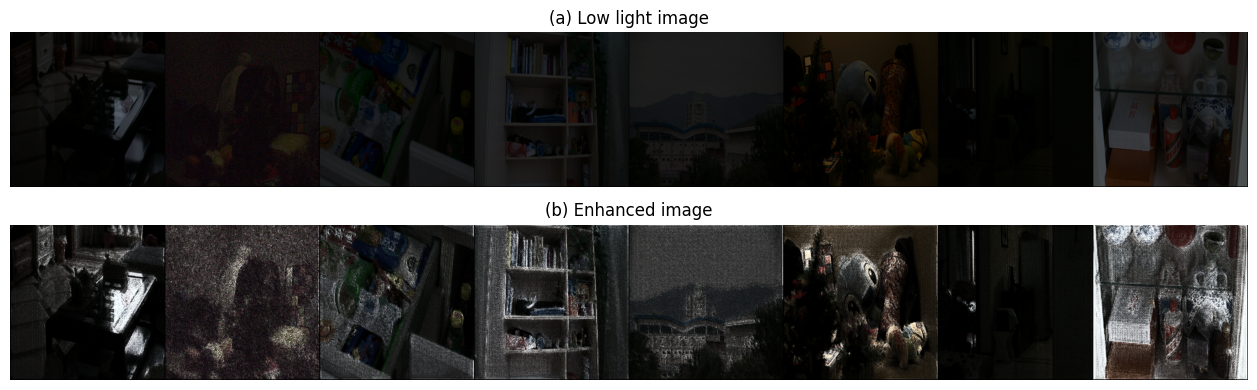

In [ ]:
plt.figure(figsize=(16, 4))
plt.subplot(2, 1, 1)
plt.title(label="(a) Low light image")
plt.imshow(X=np_img)
plt.axis(False)

plt.subplot(2, 1, 2)
plt.title(label="(b) Enhanced image")
plt.imshow(X=np_img2)
plt.axis(False)

plt.tight_layout()  # 서브플롯 간의 간격을 적절하게 맞춰줌
plt.show()


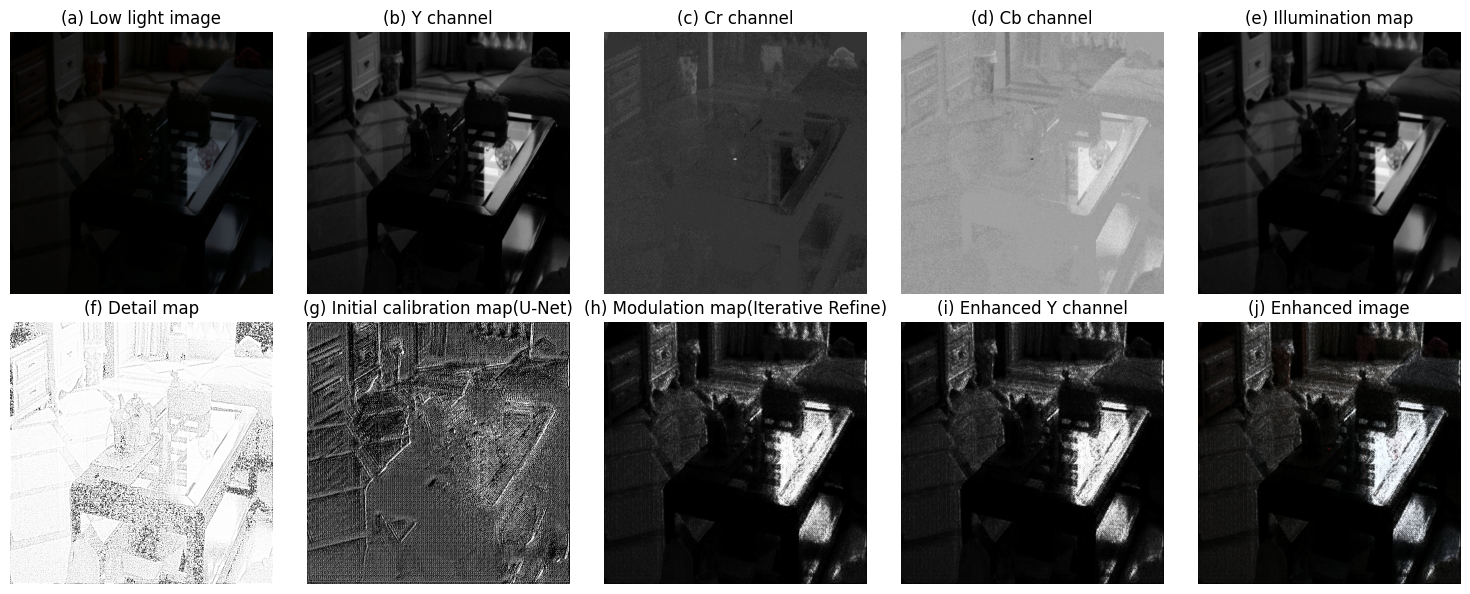

In [ ]:
plt.figure(figsize=(15, 6))  # 가로 20, 세로 5로 크게 설정

plt.subplot(2, 5, 1)
plt.imshow(X=d)
plt.title(label="(a) Low light image")
plt.axis(False)

plt.subplot(2, 5, 2)
plt.imshow(X=y, cmap='gray')
plt.title(label="(b) Y channel")
plt.axis(False)

plt.subplot(2, 5, 3)
plt.imshow(X=cr, cmap='gray')
plt.title(label="(c) Cr channel")
plt.axis(False)

plt.subplot(2, 5, 4)
plt.imshow(X=cb, cmap='gray')
plt.title(label="(d) Cb channel")
plt.axis(False)

plt.subplot(2, 5, 5)
plt.imshow(X=xi, cmap='gray')
plt.title(label="(e) Illumination map")
plt.axis(False)

plt.subplot(2, 5, 6)
plt.imshow(X=xd, cmap='gray')
plt.title(label="(f) Detail map")
plt.axis(False)

plt.subplot(2, 5, 7)
plt.imshow(X=oi, cmap='gray')
plt.title(label="(g) Initial calibration map(U-Net)")
plt.axis(False)

plt.subplot(2, 5, 8)
plt.imshow(X=ni, cmap='gray')
plt.title(label="(h) Modulation map(Iterative Refine)")
plt.axis(False)

plt.subplot(2, 5, 9)
plt.imshow(X=ny, cmap='gray')
plt.title(label="(i) Enhanced Y channel")
plt.axis(False)

plt.subplot(2, 5, 10)
plt.imshow(X=eh)
plt.title(label="(j) Enhanced image")
plt.axis(False)

plt.tight_layout()  # 서브플롯 간의 간격을 적절하게 맞춰줌
plt.show()
